In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import glob

***
### Clustering

In [2]:
# read in and plot the original data set
latent = pd.read_pickle('AET_CF_Trial_12/12_LSP_AET_CF_Predictions0')
latent = latent.replace({'trajectory-0.0': 0, 'trajectory-1.0': 1})
print(latent)

              x         y  z  index
0     -0.106338 -0.035997  1  22874
1     -0.080162 -0.039300  0  29074
2     -0.085012 -0.038035  1   5513
3     -0.083290 -0.039353  0  28012
4     -0.055159 -0.031612  1  39954
...         ...       ... ..    ...
15995 -0.110798 -0.026003  1  21872
15996 -0.038222 -0.037377  0  18223
15997 -0.088444 -0.035343  1   1407
15998 -0.078111 -0.031484  1  11873
15999 -0.094044 -0.037894  0   2276

[16000 rows x 4 columns]


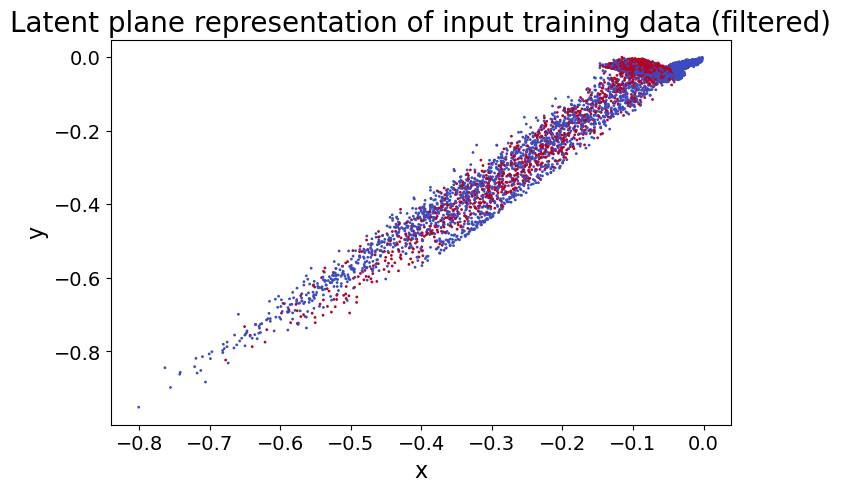

In [3]:
plt.figure(figsize = (8,5))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Latent plane representation of input training data (filtered)', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
#plt.savefig("55_data.png", dpi = 300)
plt.show()

***
### Analysis + clustering of projected data (epoch set 58)

In [4]:
# read in and plot the original data set
latent = pd.read_pickle('AET_CF_Trial_12/12_LSP_AET_CF_Predictions0')
latent = latent.replace({'trajectory-0.0': 0, 'trajectory-1.0': 1})

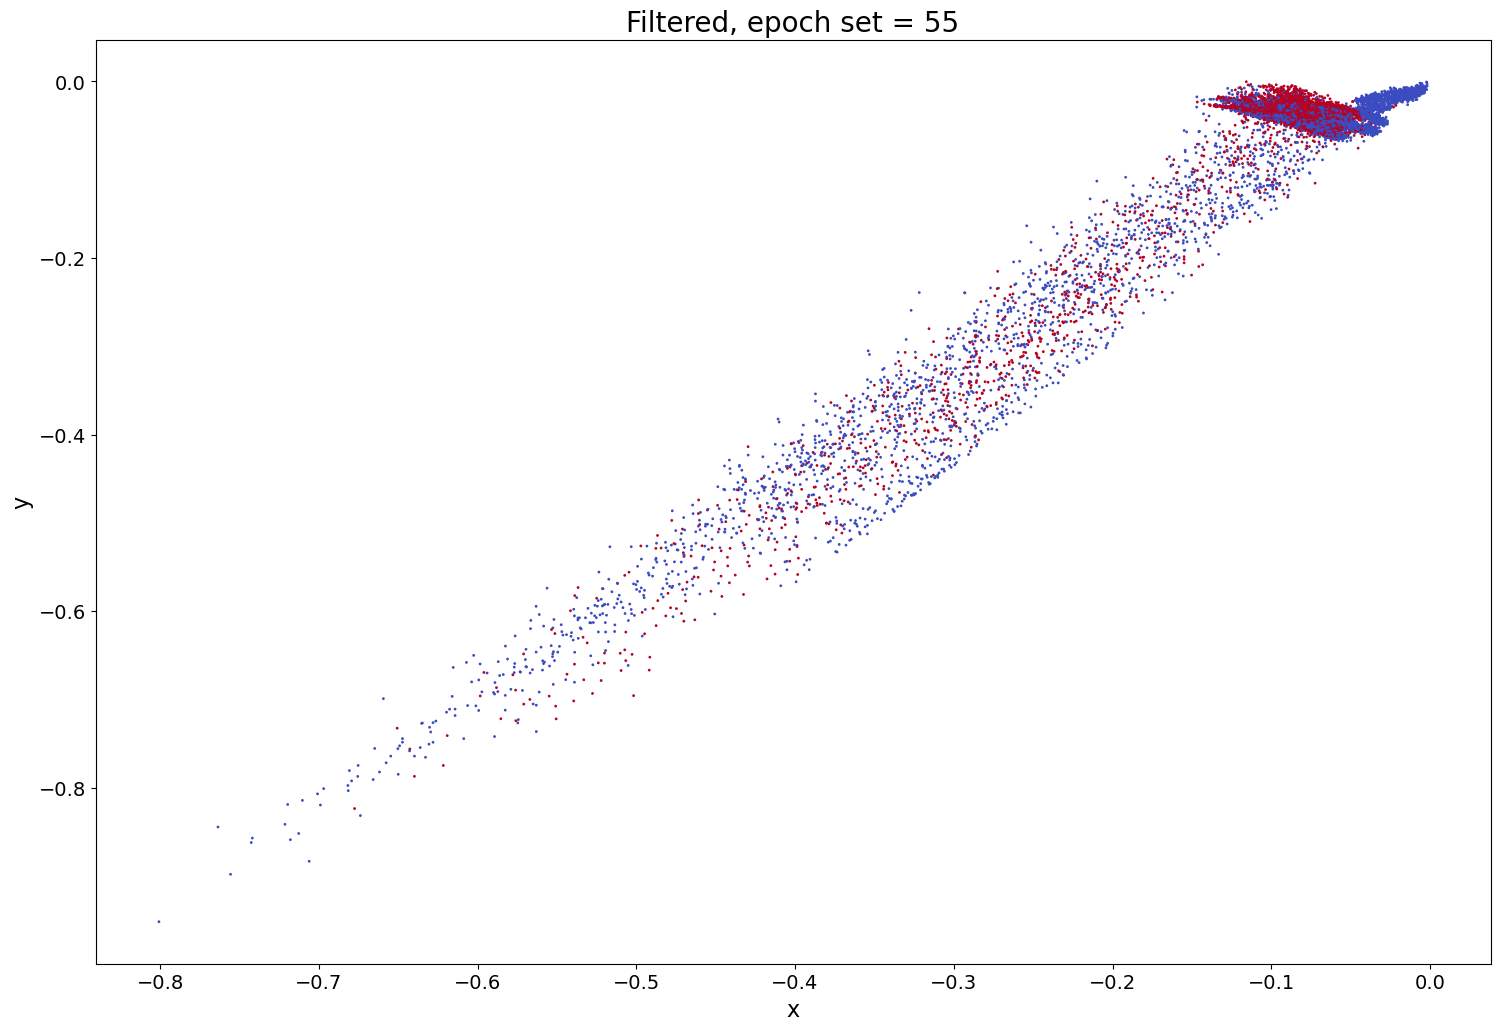

In [5]:
plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 55', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [6]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z', 'index'], axis = 1)
print(latent_n)

              x         y
0     -0.106338 -0.035997
1     -0.080162 -0.039300
2     -0.085012 -0.038035
3     -0.083290 -0.039353
4     -0.055159 -0.031612
...         ...       ...
15995 -0.110798 -0.026003
15996 -0.038222 -0.037377
15997 -0.088444 -0.035343
15998 -0.078111 -0.031484
15999 -0.094044 -0.037894

[16000 rows x 2 columns]


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def plot_knn_distances(data, k=3):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nn.kneighbors(data)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent.values, k=3)  # Adjust 'k' as needed

In [ ]:
y_pred = DBSCAN(eps=0.015, min_samples=60).fit_predict(latent_n)
plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))
plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=y_pred,s = 1)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering of the Latent Layer Representation of the Input data')
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

#print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
#print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
#s_list.append(metrics.silhouette_score(df, y_pred))

In [ ]:
import pandas as pd

# Assuming latent_n is your DataFrame after removing the 'z' column
# and latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cluster_trajectory_count is your DataFrame from the previous step

# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title('Number of WT and D132H Frames in Each Cluster')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()


In [ ]:
# Function for lc data plotting
def LCC_plot2(window, wt, mutant, alpha, ax):
    '''
    Creates LCC plot for wt and mutant data for different window sizes
    '''
    
    wt = wt.to_numpy()
    mutant = mutant.to_numpy()
    
    frame_number_wt = wt.shape[0]
    frame_number_mutant = mutant.shape[0]
    
    #print('Number of trajectory frames read in (WT): ', frame_number_wt, '\n',
    #      'Number of trajectory frames read in (mutant): ', frame_number_mutant)
            
    upper_limit = 70 + 1 - window # max protein length + 1
    
    x = np.arange(1 + window / 2, upper_limit + window / 2) + 90
         
    for z in range(wt.shape[0]):
        y = wt[z]
        lcc = ax.plot(x, y, color = 'blue', alpha = alpha)
    
    for z in range(mutant.shape[0]):  
        k = mutant[z]
        lcc = ax.plot(x, k, color = 'red', alpha = alpha)
        
    ax.set_xlabel('Amino Acid Sequence Position')  
    ax.set_ylabel('Distance ($\AA$)') 
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    plot_name = 'Window Size ' + str(window) + ' aa'
    ax.set_title(plot_name)
    
    
    return lcc

In [ ]:
# LC plot for frames in each cluster (excluding noise)
for lab in clust_lab58[1:]:
    
    print('CLuster lab :', lab)
    
    plt.rcParams['font.size'] = '18'
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (16,16), constrained_layout=True)

    for i, window in enumerate([3,12,20]):
        
        wt_data1_index58 = clust_ind_dict_wt58['{}'.format(lab)]
        wt_data158 = wt_dict[window].iloc[wt_data1_index58,:]
        D132H_data1_index58 = clust_ind_dict_mut58['{}'.format(lab)]
        D132H_data158 = D132H_dict[window].iloc[D132H_data1_index58,:]
        
        LCC_plot2(window, wt_data158, D132H_data158, 0.002, (axes.flat)[i])

    plt.show()